In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import spacy
from pymystem3 import Mystem
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import time

import emoji

In [2]:
columns = ['comment', 'date_time', 'color','size', 'thumb_up', 'thumb_down', 'prod_eval', 'prod', 'brand']

df = pd.read_json('./input/file_7961412_455951711_109.jl').transpose().reset_index().drop('index', axis=1)
df = df.set_axis(columns, axis = 'columns')

df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind


# Stopwords extension

In [3]:
# нужно обновить стоп-слова, добавив как миниму то, что в облаке. Сейчас использую стоп-слова NLTK, 
# но стоит сравнить с другими
russian_stopwords = stopwords.words("russian")

russian_stopwords.extend(['очень', 'хороший', 'отличный', 'свой', 'отзыв', 'миксер', 'супер','это', 'спасибо', 'работа',
                          re.sub(r'[.,?!@#~`$%^&*_+-=]', '', df['brand'][0].lower()), 
                          re.sub(r'[.,?!@#~`$%^&*_+-=]', '', df['prod'][0].lower())])
#print(len(russian_stopwords))
#print(len(russian_stopwords))

In [4]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind


# Очистка текста (эмодзи, стоп-слова, символы)

In [5]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

    text = text.translate(string.punctuation)
    text = text.lower().split()
    text = [w for w in text if not w in russian_stopwords and len(w) >= 3]
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[,!.\/'+-=)(]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\%", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\|", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(text.split())
    

    return text


In [6]:
%time
df['cleaned_comment'] = df['comment'].map(lambda x: clean_text(x))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 25 µs


In [7]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...


# Mystem и удаление опустевших комментов

In [8]:
df[df['cleaned_comment']=='']

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
71,Отличный миксер,2021-03-25T05:30:48Z,фиолетовый,0,2,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
87,Отличный миксер,2021-03-15T06:29:58Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,
188,Отличный миксер,2021-01-05T11:04:48Z,фиолетовый,0,1,2,5,Миксер планетарный SPM7167 1600Вт,StarWind,
217,Супер миксер,2021-01-02T13:21:52Z,фиолетовый,0,2,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
474,Отличный миксер,2020-11-25T06:30:41Z,фиолетовый,0,1,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
484,😍😍😍👍👍👍,2020-11-23T09:34:17Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
505,Отличный миксер,2020-11-20T04:56:31Z,фиолетовый,0,3,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,


In [9]:
df = df.drop(df[df['cleaned_comment']==''].index)

In [10]:
def lemmatize(text): 
    text =  [i for i in text]
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    count = 0
    lemma = m.lemmatize(merged_text)
    for t in lemma:
        
        if t != '|' and count+1<len(lemma):
            doc.append(t)
            count+=1
          
        else:
            doc = ''.join(i for i in doc)
            res.append(doc)
            count+=1
            doc = []
    return res

In [11]:
%time
res = lemmatize(df['cleaned_comment'])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 28.4 µs


In [12]:
df['lemma_comment'] = res

In [13]:
%time
df['lemma_comment'] = df['lemma_comment'].map(lambda x: clean_text(x))
df = df.drop(df[df['lemma_comment']==''].index)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [14]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился,зверь машина понравиться
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую,аллах советовать
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...,приходить целое попробовать понравиться шумный...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...,хотеть долго выбирать купить красивый цвет раб...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...,сегодня получать сразу опробовать дело успеват...


In [15]:
df = df.reset_index(drop = True)

In [16]:
preprocessed_comments = df['lemma_comment']

# Word cloud

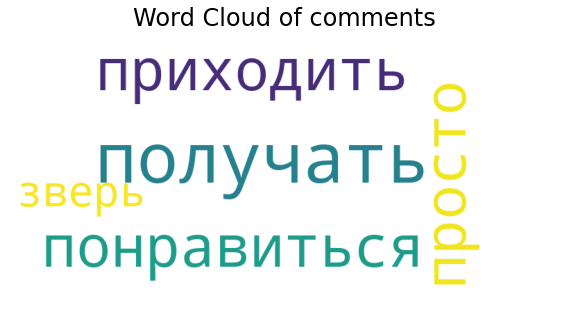

In [22]:
def plot_wordcloud(preprocessed_comments, mask=None, max_words=5, max_font_size=100, figure_size=(8.0,8.0), 
                   title = None, title_size=24, image_color=False):
    stopwords = {}
    wordcloud = WordCloud(background_color='white',
                    mask=None,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 666,
                    contour_width=1,
                    contour_color='black',
                    width=800, 
                    height=400,
                    )
    wordcloud.generate(str(preprocessed_comments))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
plot_wordcloud(preprocessed_comments, title="Word Cloud of comments")

# tf-idf

In [23]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

In [24]:
vectorized_comments = vectorizer.fit_transform(preprocessed_comments)

In [25]:
#  creating a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [26]:
#Эти слова показываем пользователю, он вводит то, по чему хочет почитать подробнее, или свое слово
tfidf.sort_values(by=['tfidf'], ascending=True).head(5)

,tfidf
приходить,2.476278
работать,2.578756
тесто,2.630428
довольный,2.653418
взбивать,2.785842


# Looking for most similar comments for each word

In [28]:
nlp = spacy.load('ru_core_news_lg')

In [30]:
def top_10_similar(word_for_checking, dataframe):
    critical_similarity_value = 0.4
    
    word_for_checking = nlp(word_for_checking)
    similarities = []
    for i in range(len(dataframe['lemma_comment'])):
        similarities.append(nlp(dataframe['lemma_comment'][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    #сортировка по убыванию similarities, фильтрация в соответствии с critical_similarity_value
    df_temp = df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)
    res = df_temp[df_temp[f'similarity_to_{word_for_checking}'] > critical_similarity_value][['comment', f'similarity_to_{word_for_checking}']]
    res = list(res['comment'])
    
    if len(res)>0:
        return res
    else: 
        return "По вашему запросу совпадений не найдено"

In [32]:
top_10_similar('приходить', df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  import sys


['Наконец-то пришел миксер. Заказала 16.11, а пришел он аж 06.12... Ждала очень долго. Сам миксер огонь. Не пожалела ни разу. ',
 'Пришёл со всеми комплектующими. ',
 'Миксер получила,пришел целый,ничего не разбилось при транспортировке,проверили все работает.',
 'Пришёл бракованный. Его уже раньше возвращали.',
 'Пришёл без одной насадки, буду перезаказывать.',
 'Пришло все в отличном состоянии! Все супер! Работает на ура!!! Рекомендую!',
 'Всë пришло как в описании, он очень красивый, спасибо😊. Советую,😊',
 'Брали в подарок, все пришло целое. ',
 'Красивый. Всё пришло. запечатано все отлично. Работает. В деле не применяли ещё.',
 'Товар пришёл во время, оплатила курьера, чтоб доставили, хотя вроде свыше 3т доставка должна быть бесплатной, прождала  2 дня, ни кто не доставил, начала искать куда пришёл товар, оказывается вообще на другой конец города, пришлось ехать и забирать. Теперь интересно деньги вернут за курьера?']

In [19]:
# пока не работает с неизвестными словами, например, "маломерит"
# если пишешь плохое качество, то выдача вроде та же, что и на хорошее
# вся работа у меня заняла 30 секунд